# 复现
将[叶佳伟博士的论文](https://doi.org/10.1016/j.watres.2022.118828)3.1案例，即水锤方程模拟的代码进行改写，将tensorflow1.0改为pytorch

In [81]:
import numpy as np
import torch
import math

In [7]:
import warnings
from collections import OrderedDict
warnings.filterwarnings('ignore')

In [8]:
np.random.seed(124)
torch.manual_seed(134)
np.set_printoptions(threshold=1000) # the length of numpy print out
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
flag=torch.cuda.is_available()
flag

True

In [10]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = torch.nn.Tanh()

        layer_list = list()
        for i in range(self.depth):
            linear_layer = torch.nn.Linear(layers[i], layers[i + 1])
            # torch.nn.init.xavier_normal_(linear_layer.weight)
            layer_list.append(('layer_%d' % i, linear_layer))
            if i!=self.depth-1: # last layer don't need tanh
                layer_list.append(('activation_%d' % i, self.activation))

        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.net = torch.nn.Sequential(layerDict)

    def forward(self, x):
        lb=torch.tensor([x[0,0],x[0,1]]).float().to(device)
        ub=torch.tensor([x[-1,0],x[-1,1]]).float().to(device)
        normx=2.0 * (x - lb) / (ub - lb) - 1.0
        out = self.net(normx)  # return layers=3
        return out

    def initialize(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                # normal: mean=0, std=sqrt(l_in+l_out)
                print("运行一次isinstance")
                torch.nn.init.xavier_normal_(m.weight.data)
                torch.nn.init.constant_(m.bias.data, 0)
            else:
                print("运行一次else")

In [12]:
# test my DNN
model_test=DNN([2]+[20]*2+[2])
model_test

DNN(
  (activation): Tanh()
  (net): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [13]:
for layer,param in model_test.state_dict().items(): # param is weight or bias(Tensor)
	print(layer,param)

net.layer_0.weight tensor([[ 0.3102,  0.4376],
        [ 0.1805, -0.0099],
        [ 0.2869,  0.5470],
        [ 0.3763,  0.6707],
        [-0.3406, -0.1804],
        [-0.5065, -0.3945],
        [-0.4419,  0.6213],
        [-0.2693, -0.6878],
        [ 0.4627, -0.2240],
        [ 0.5264,  0.3824],
        [-0.2506, -0.2178],
        [-0.2601,  0.5622],
        [-0.5601,  0.5212],
        [ 0.2394, -0.3474],
        [ 0.3321,  0.3241],
        [-0.1392, -0.1575],
        [-0.4867, -0.1081],
        [ 0.4836,  0.2567],
        [ 0.1645,  0.6883],
        [-0.6946,  0.5191]])
net.layer_0.bias tensor([-0.0890, -0.2897, -0.3644,  0.4670, -0.4528,  0.0665,  0.2072, -0.6308,
        -0.4620, -0.3029,  0.3035,  0.0452,  0.0251, -0.6675,  0.5785,  0.1270,
         0.1846, -0.4631,  0.0119, -0.6618])
net.layer_1.weight tensor([[ 1.8632e-01, -1.8134e-01, -1.3440e-02, -1.9496e-02, -1.2810e-01,
         -1.0957e-01, -1.5293e-01, -1.9052e-01, -8.2692e-02,  7.2648e-02,
         -6.0797e-02,  8.8321e-

In [127]:
class PhysicsInformedNN():
    def __init__(self, X, X_obs, U_obs, layers, lb, ub):

        # boundary conditions
        self.lb = torch.tensor(lb,requires_grad=False).float().to(device)
        self.ub = torch.tensor(ub,requires_grad=False).float().to(device)

        # data interior
        self.t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        # observer data
        self.t_obs = torch.tensor(X_obs[:, 0:1], requires_grad=True).float().to(device)
        self.x_obs = torch.tensor(X_obs[:, 1:2], requires_grad=True).float().to(device)
        self.h_obs = torch.tensor(U_obs[:, 0:1], requires_grad=False).float().to(device)

        # weight
        self.weight=0.1

        # # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.initialize()

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.001,
            max_iter=500000,
            max_eval=500000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"  # can be "strong_wolfe"
        )
        # self.optimizer = torch.optim.LBFGS( self.dnn.parameters())

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        # remenber loss
        self.loss_pdes=[]
        self.loss_observaitons=[]
        self.losses=[]

    def get_r(self, x, t):
        # settings
        fric = 0.0012 #  m(^-1/3)/s
        Dia = 1.81 # m
        w_a = 1000.0 # m/s
        g = 9.81
        Afull=3.14*Dia *Dia /4

        # 获取qai
        h_and_q = self.dnn(torch.cat([x, t], dim=1))
        h_ = h_and_q[:, 0:1]
        q_ = h_and_q[:, 1:2]

        h_t = torch.autograd.grad(h_, t, grad_outputs=torch.ones_like(t), retain_graph=True)[0]
        h_x = torch.autograd.grad(h_, x, grad_outputs=torch.ones_like(x), retain_graph=True)[0]
        q_t = torch.autograd.grad(q_, t, grad_outputs=torch.ones_like(t), retain_graph=True)[0]
        q_x = torch.autograd.grad(q_, x, grad_outputs=torch.ones_like(x), retain_graph=True)[0]

        mass = Afull * q_t + q_ * q_x + g * Afull * Afull * h_x+fric*q_*torch.abs(q_)/2/Dia
        momentum = Afull* h_t + q_ * h_x + w_a * w_a * q_x / g

        return h_,q_,mass, momentum


    def train(self, nIter1):

        self.dnn.train()
        for epoch in range(nIter1):
            r_h_init, _, r_mass_init, r_momentum_init = self.get_r(self.x_obs, self.t_obs)
            _, _, r_mass_inr, r_momentum_inr = self.get_r(self.x, self.t)

            loss_pde1=torch.sum(torch.square(r_mass_init)+torch.square(r_momentum_init))
            loss_pde2=torch.sum(torch.square(r_mass_inr)+torch.square(r_momentum_inr))
            loss_pde=loss_pde1+loss_pde2

            loss_obs=torch.sum(torch.square(self.h_obs-r_h_init))

            # 自适应
            # if loss_pde>loss_obs:
            #     tmp=math.ceil(torch.log10(loss_pde)-torch.log10(loss_obs))
            #     self.weight=np.power(0.1,tmp)

            # 自适应
            # if loss_pde>loss_obs:
            #     tmp=math.ceil((torch.log10(loss_pde)-torch.log10(loss_obs))*0.5)
            #     self.weight=np.power(0.1,tmp)

            # # # 自适应
            # if loss_pde>loss_obs:
            #     tmp=int((torch.log10(loss_pde)-torch.log10(loss_obs)))
            #     self.weight=np.power(0.1,tmp)

            loss = self.weight*loss_pde+loss_obs


            # Backward
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            if epoch % 100 == 0:

                #self.optimizer.step
                self.loss_pdes.append(loss_pde)
                self.loss_observaitons.append(loss_obs)
                self.losses.append(loss)
                print(
                    'It: %d, Loss: %.3e, PDE: %.3e, PDE1: %.3e, PDE2: %.3e, Obs: %.3e' %
                    (
                        epoch,
                        loss.item(),
                        loss_pde,
                        loss_pde1,
                        loss_pde2,
                        loss_obs
                    )
                )



    # 输出预测值
    def predict(self, X):
        t = torch.tensor(X[:, 0:1]).float().to(device)
        x = torch.tensor(X[:, 1:2]).float().to(device)

        self.dnn.eval()

        hstar_and_qstar = self.dnn(torch.cat([x, t], dim=1))
        hstar = hstar_and_qstar[:, 0:1]
        qstar = hstar_and_qstar[:, 1:2]

        return hstar, qstar

# 获取数据

In [15]:
# read csv: hOBS
data= np.loadtxt(open("../data/case0.csv","rb"),delimiter=",",skiprows=1)
data=data[::5,:]
data # No-T-(N1_N102)

array([[0.0000000e+00, 1.0000000e-02, 1.0000000e+02, ..., 3.1400000e-01,
        9.9997480e+01, 3.1400000e-01],
       [5.0000000e+00, 6.0000000e-02, 1.0000000e+02, ..., 3.4823000e-01,
        9.8288480e+01, 3.5714000e-01],
       [1.0000000e+01, 1.1000000e-01, 1.0000000e+02, ..., 3.9278000e-01,
        9.6532620e+01, 4.0146000e-01],
       ...,
       [1.0850000e+03, 1.0860000e+01, 1.0000000e+02, ..., 6.8860000e-02,
        1.1275714e+02, 7.3450000e-02],
       [1.0900000e+03, 1.0910000e+01, 1.0000000e+02, ..., 1.1087000e-01,
        1.1133188e+02, 1.2005000e-01],
       [1.0950000e+03, 1.0960000e+01, 1.0000000e+02, ..., 1.5802000e-01,
        1.0924141e+02, 1.6954000e-01]])

In [16]:
reaches = 51
length = 500
t_space=data[:,1]
x_space = np.linspace(0, length, reaches)

In [17]:
# Get pressure
p_all = np.zeros(shape=(reaches, len(data)))
for i in range(reaches):
    p_all[i] = data[:, 2 * i + 2]
# Get flow
q_all = np.zeros(shape=(reaches, len(data)))
for i in range(reaches):
    q_all[i] = data[:, 2 * i + 3]

p_all.shape

(51, 220)

# 制作训练数据集合
### 网络参数值

In [18]:
layers = [2] + [20] * 8 + [2]
layers

[2, 20, 20, 20, 20, 20, 20, 20, 20, 2]

In [19]:
N_collo = 20  # number of collocation points
tlen = 199  # time points for training

In [20]:
lb = np.array([0., 0.])
ub = np.array([length, t_space[tlen]])  # x and t?

### 问题域点集

In [21]:
# 相当于meshgrid，通过监测数据来布置所有数据集合xt
x_all = np.tile(x_space, (len(data), 1)).transpose()  # shape(reaches,steps)
t_all = np.tile(t_space, (reaches, 1))  # time shape(steps,steps)

### 观测点点集

In [22]:
# Training Data
idx = np.array([5,20,50],dtype='int') # index for training data
x_obs_train = np.zeros(shape=(len(idx), tlen))
t_obs_train = np.zeros(shape=(len(idx), tlen))
h_obs_train = np.zeros(shape=(len(idx), tlen))

In [23]:
# set training data, observation
for i in range(0, len(idx)):
    x_obs_train[i] = x_all[idx[i]][0:tlen]
    t_obs_train[i] = t_all[idx[i]][0:tlen]
    h_obs_train[i] = p_all[idx[i]][0:tlen]

### 测试点点集

In [24]:
# Collocation Dataset
idx_collo =  np.linspace(0,reaches-1,N_collo,dtype='int')

x_collo_train = np.zeros(shape=(len(idx_collo), tlen))
t_collo_train = np.zeros(shape=(len(idx_collo), tlen))

for i in range(0, len(idx_collo)):
    x_collo_train[i] = x_all[idx_collo[i]][0:tlen]
    t_collo_train[i] = t_all[idx_collo[i]][0:tlen]

### 转换为tensor

In [25]:
# Flatten data for DNN
x_obs_train_flat = torch.tensor(x_obs_train.flatten()[:, None])
t_obs_train_flat = torch.tensor(t_obs_train.flatten()[:, None])
h_obs_train_flat = torch.tensor(h_obs_train.flatten()[:, None])
x_all_flat=torch.tensor(x_all.flatten()[:,None])
t_all_flat=torch.tensor(t_all.flatten()[:,None])
x_collo_train_flat = torch.tensor(x_collo_train.flatten()[:, None])
t_collo_train_flat = torch.tensor(t_collo_train.flatten()[:, None])

In [26]:
#def __init__(self, X, X_obs, U_obs, layers, lb, ub):
X = torch.cat([t_collo_train_flat, x_collo_train_flat], dim=1)
X_obs=torch.cat([t_obs_train_flat, x_obs_train_flat], dim=1)
U_obs=h_obs_train_flat

In [45]:
X

tensor([[1.0000e-02, 0.0000e+00],
        [6.0000e-02, 0.0000e+00],
        [1.1000e-01, 0.0000e+00],
        ...,
        [9.8100e+00, 5.0000e+02],
        [9.8600e+00, 5.0000e+02],
        [9.9100e+00, 5.0000e+02]], dtype=torch.float64)

### 数据可视化

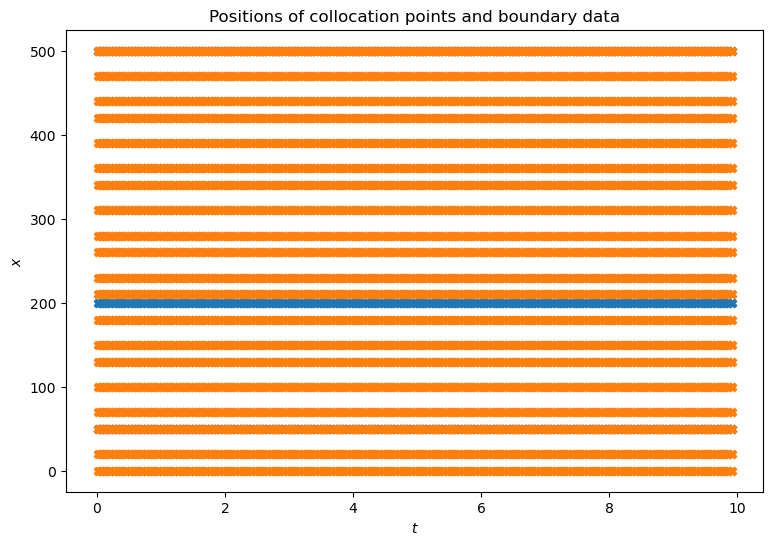

In [28]:
import matplotlib.pyplot as plt

fig0 = plt.figure(figsize=(9, 6))
plt.scatter(t_obs_train, x_obs_train, marker='X', vmin=-1, vmax=1)
plt.scatter(t_collo_train, x_collo_train, marker='X', vmin=-1, vmax=1)
#plt.scatter(t_all, x_all, marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
plt.show()

# 开始训练

In [128]:
# training
model = PhysicsInformedNN(X=X, X_obs=X_obs, U_obs=U_obs, layers=layers, lb=lb, ub=ub)
model.train(400000)

运行一次else
运行一次else
运行一次else
运行一次isinstance
运行一次isinstance
运行一次isinstance
运行一次isinstance
运行一次isinstance
运行一次isinstance
运行一次isinstance
运行一次isinstance
运行一次isinstance
It: 0, Loss: 6.033e+06, PDE: 3.945e+06, PDE1: 6.378e+05, PDE2: 3.307e+06, Obs: 6.033e+06
It: 100, Loss: 5.314e+06, PDE: 1.599e+02, PDE1: 3.593e+01, PDE2: 1.240e+02, Obs: 5.314e+06
It: 200, Loss: 5.035e+06, PDE: 1.814e+00, PDE1: 4.424e-01, PDE2: 1.371e+00, Obs: 5.035e+06
It: 300, Loss: 4.791e+06, PDE: 1.800e-01, PDE1: 4.387e-02, PDE2: 1.361e-01, Obs: 4.791e+06
It: 400, Loss: 4.564e+06, PDE: 3.946e-02, PDE1: 9.282e-03, PDE2: 3.018e-02, Obs: 4.564e+06
It: 500, Loss: 4.349e+06, PDE: 1.428e-02, PDE1: 3.074e-03, PDE2: 1.121e-02, Obs: 4.349e+06
It: 600, Loss: 4.143e+06, PDE: 7.685e-03, PDE1: 1.447e-03, PDE2: 6.238e-03, Obs: 4.143e+06
It: 700, Loss: 3.945e+06, PDE: 5.494e-03, PDE1: 9.072e-04, PDE2: 4.587e-03, Obs: 3.945e+06
It: 800, Loss: 3.755e+06, PDE: 4.639e-03, PDE1: 6.964e-04, PDE2: 3.943e-03, Obs: 3.755e+06
It: 900, Loss: 3.573e

# 预测

In [129]:
h_pred_train, _ = model.predict(X_obs)
h_pred_train.cpu().detach().numpy()

array([[100.027374],
       [ 99.983765],
       [ 99.98773 ],
       [ 99.99743 ],
       [ 99.97407 ],
       [100.03824 ],
       [100.020966],
       [ 99.94481 ],
       [100.05495 ],
       [ 99.965866],
       [ 98.234184],
       [ 96.536705],
       [ 96.57171 ],
       [ 97.3237  ],
       [ 98.2793  ],
       [ 99.39636 ],
       [100.641   ],
       [101.82532 ],
       [102.67134 ],
       [103.0053  ],
       [102.826485],
       [102.20718 ],
       [101.26714 ],
       [100.19634 ],
       [ 99.22028 ],
       [ 98.643036],
       [ 98.57193 ],
       [ 98.91577 ],
       [ 99.75503 ],
       [100.75864 ],
       [103.34765 ],
       [105.73904 ],
       [106.25343 ],
       [105.642296],
       [104.24289 ],
       [101.892365],
       [ 99.27414 ],
       [ 96.7697  ],
       [ 94.76081 ],
       [ 93.797615],
       [ 93.81687 ],
       [ 94.665054],
       [ 96.1784  ],
       [ 98.05307 ],
       [ 99.78461 ],
       [100.99241 ],
       [101.6553  ],
       [101.8

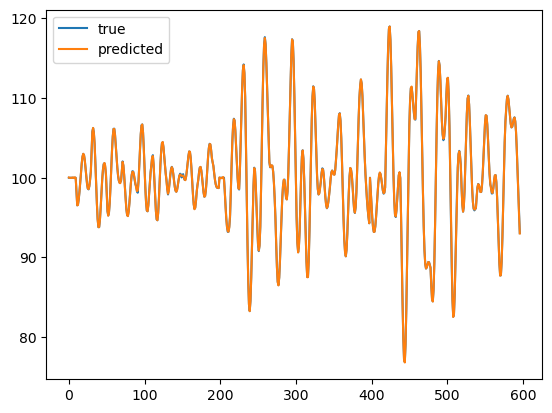

In [130]:
# 观测点预测值与实际值
plt.figure(1)
plt.plot(h_obs_train_flat.cpu().detach().numpy(), label='true')
plt.plot(h_pred_train.cpu().detach().numpy(), label='predicted')
plt.legend()

In [131]:
Ntest = 10
tlen = 200
idx_test = np.arange(0, 51, 5)

In [132]:
x_test = np.zeros(shape=(len(idx_test), tlen))
t_test = np.zeros(shape=(len(idx_test), tlen))
p_test = np.zeros(shape=(len(idx_test), tlen))
q_test = np.zeros(shape=(len(idx_test), tlen))
for i in range(0, len(idx_test)):
    x_test[i] = x_all[idx_test[i]][0:tlen]
    t_test[i] = t_all[idx_test[i]][0:tlen]
    p_test[i] = p_all[idx_test[i]][0:tlen]
    q_test[i] = q_all[idx_test[i]][0:tlen]
x_test_flat = torch.tensor(x_test.flatten()[:, None])
t_test_flat = torch.tensor(t_test.flatten()[:, None])
p_test_flat = torch.tensor(p_test.flatten()[:, None])
q_test_flat = torch.tensor(q_test.flatten()[:, None])

In [133]:
X_test=torch.cat([t_test_flat, x_test_flat], dim=1)
h_pred, q_pred = model.predict(X_test)

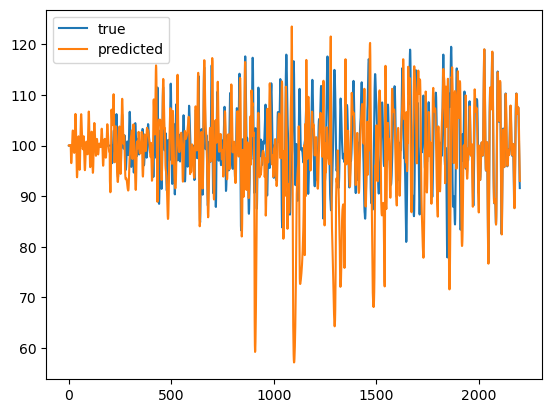

In [134]:
# 压力预测值
plt.figure(2)
plt.plot(p_test_flat.cpu().detach().numpy(), label='true')
plt.plot(h_pred.cpu().detach().numpy(), label='predicted')
plt.legend()

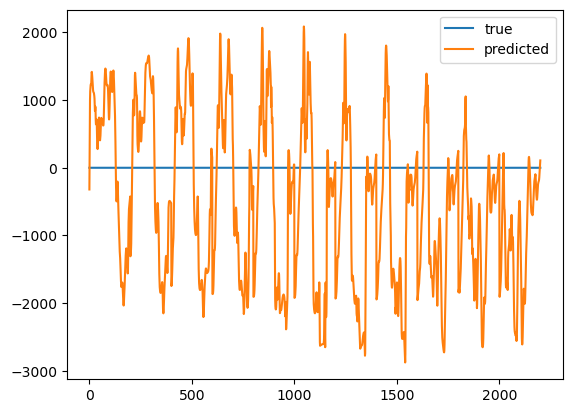

In [135]:
# 流量预测值
plt.figure(3)
plt.plot(q_test_flat.cpu().detach().numpy(), label='true')
plt.plot(q_pred.cpu().detach().numpy(), label='predicted')
plt.legend()

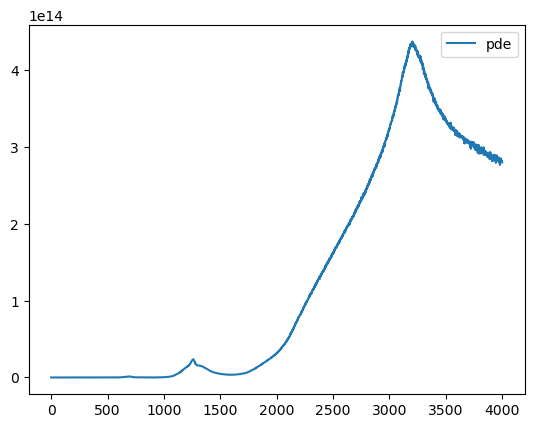

In [94]:
# 损失函数线
plt.figure(4)
plt.plot(torch.stack(model.loss_pdes,dim=0).cpu().detach().numpy(), label='pde')
plt.legend()

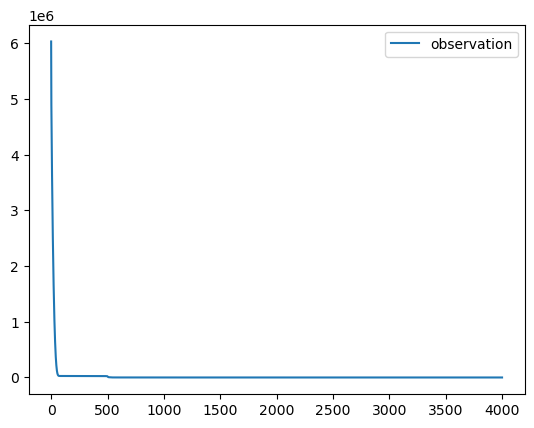

In [95]:
plt.figure(5)
plt.plot(torch.stack(model.loss_observaitons,dim=0).cpu().detach().numpy(), label='observation')
plt.legend()

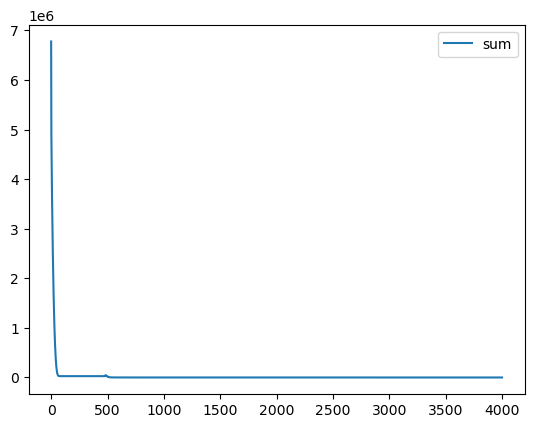

In [96]:
plt.figure(6)
plt.plot(torch.stack(model.losses,dim=0).cpu().detach().numpy(), label='sum')
plt.legend()

In [68]:
import netron

In [69]:
torch.onnx.export(
    model.dnn,
    torch.randn(3,2).to(device),
    'save/model_torch.onnx',
    export_params=True,
    opset_version=8,
)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

